In [1]:
import numpy as np
import torch
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.path as mpath
import sys
sys.path.append('/remote/tychodata/ftairli/work/Projects/MuonSignal/Models')

In [2]:
plt.rcParams['figure.figsize'] = [15, 12]

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('Using Device:', device)

Main  = torch.load('../Data/NormData/Main_test.pt')
Aux   = torch.load('../Data/NormData/Aux_test.pt')
Truth = torch.load('../Data/NormData/Truth_test.pt')
EventMyId = torch.load('../Data/NormData/EventMyId_test.pt')

Aux = Aux.unsqueeze(2)
Truth = Truth.unsqueeze(2)

Main = Main.transpose(1,2)

# Truth = Truth.sum(dim=1).unsqueeze(1)
print(Main.shape, Aux.shape, Truth.shape)

Using Device: cuda
torch.Size([169157, 120, 3]) torch.Size([169157, 4, 1]) torch.Size([169157, 120, 1])


In [4]:
print(Aux.shape)
print(Aux.squeeze().unsqueeze(1).shape)
print(Aux.transpose(1,2).shape)

torch.Size([169157, 4, 1])
torch.Size([169157, 1, 4])
torch.Size([169157, 1, 4])


In [5]:
Name = 'Model_1_4'
model   = torch.load(f'../Models/{Name}.pt')
# from Model_1_0 import Model_1_2
# model = Model_1_2()
Tracker = torch.load(f'../Models/{Name}_Tracker.pt')


WantedEpoch = len(Tracker.ModelStates)
print(WantedEpoch)
model.load_state_dict(Tracker.ModelStates[WantedEpoch-1])
print(model.Name)


# Truth = model.UnnormaliseY(Truth).sum(dim=1)/model.UnnormaliseY(Main).mean(dim=2).sum(dim=1).unsqueeze(1)



100
Model_1_4


In [6]:
print(Truth.shape)

torch.Size([169157, 120, 1])


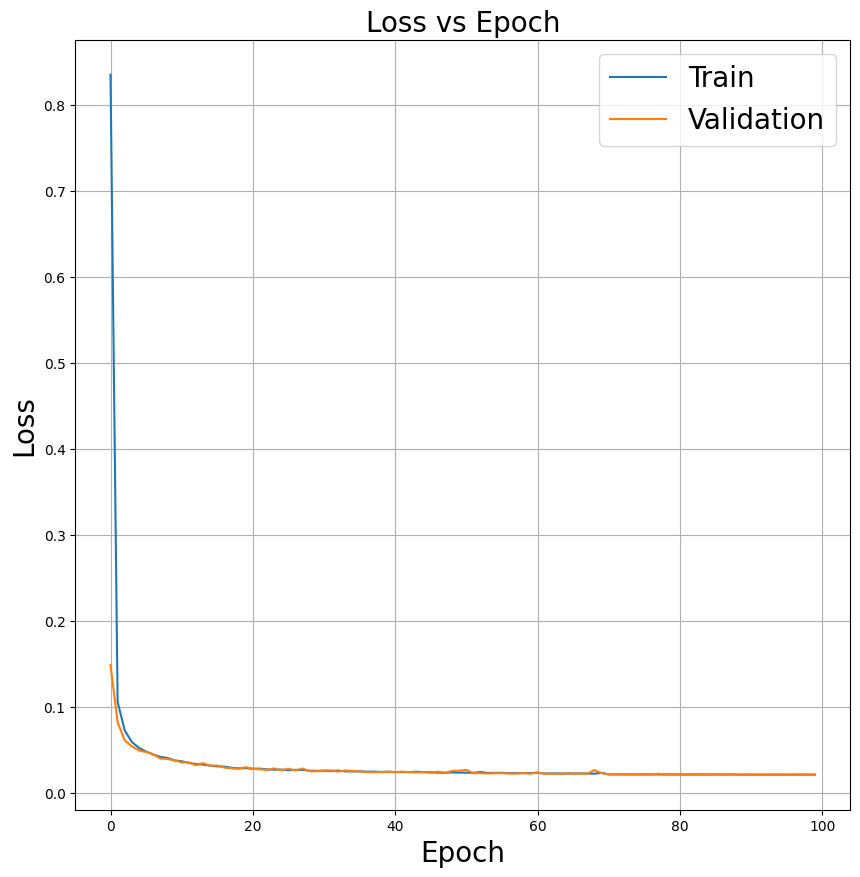

In [26]:
plt.figure(figsize=(10,10))
plt.plot(Tracker.EpochLoss)
plt.plot(Tracker.EpochValLoss)
plt.title('Loss vs Epoch',fontsize= 20)
plt.ylabel('Loss',fontsize= 20)
plt.xlabel('Epoch',fontsize= 20)
plt.legend(['Train', 'Validation'], loc='upper right',fontsize= 20)
plt.grid()
plt.show()


In [8]:

model = model.to(device)
model.eval()

from Model_1_0 import MyDataset
from torch.utils.data import DataLoader

BatchSize      = 100


test_dataset = MyDataset(Main,Aux,Truth)
dataloader_test = DataLoader(test_dataset,batch_size=BatchSize)

pred  = np.zeros(shape = (Main.shape[0],120,1))
truth = np.zeros(shape = (Main.shape[0],120,1))

filled = 0
BatchN = 0
print('Beginging to compute')
with torch.no_grad():
    for batch_Main,batch_Aux,batch_Truth in dataloader_test:

        print(f'\rBatch {BatchN} of {len(dataloader_test)}',end='')

        batch_Main = batch_Main.to(device)
        batch_Aux = batch_Aux.to(device)
        Current_BatchSize = batch_Main.shape[0]
        
        Results = model(batch_Main,batch_Aux)
        Truths  = batch_Truth
        Results = model.UnnormaliseY(Results)
        Truths  = model.UnnormaliseY(Truths)

        pred[filled: filled+Current_BatchSize] = Results.cpu().numpy()
        truth[filled: filled+Current_BatchSize] = Truths.cpu().numpy()
        
        filled += Current_BatchSize
        BatchN += 1

# del model

Beginging to compute
Batch 1691 of 1692

In [36]:
for i in range(50):
    N = np.random.randint(len(Main))
    X = np.arange(0,120,1)*25
    plt.figure(figsize=(15,10))
    plt.plot(X,pred[N],label='pred')
    plt.plot(X,truth[N],label='truth')
    plt.plot(X,model.UnnormaliseY(Main[N].mean(dim=1)),label='Total',color = 'k')
    plt.legend(fontsize = 20)
    plt.xlabel('Time',fontsize= 20)
    plt.ylabel('VEM',fontsize=20)
    plt.grid()
    # plt.show()
    plt.savefig(f'../Results/TracePrediction_Example_{i}.png')
    plt.close()